# Fetching data from API endpoint
#### - download the data day by day using for loop and convert each day to a CSV file so I can detect and filter the visitors only (not passersby) in the next step.

In [ ]:
# fetching data from endpoint 
import pandas as pd
import requests
import json

def main_request(url, headers):
    response = requests.get(url, headers=headers)

    # Print the status code to check whether the fetch process was completed correctly or not on a specific day.
    print("Status Code", response.status_code)
    data = response.json()
    return data

for i in range (1,31):
  data = main_request(f"https://wmc.dev.hoopoe.digital/api/meraki/sip/7/{i}", {"x-api-key": "1eb6e1d7-f41f-4202-a29e-607f6dd7c648"})
  # convert json data to dataframe 
  df1 = pd.DataFrame(data)
  # convert datafram to CSV file
  df1.to_csv(f"day {i}.csv", index = False)
  del df1

# Detect the visitors only (not passersby):
## steps :
- convert the "time" column to datetime data type so I can extract a lot of information from like hours, minutes, and second 
- create a new column containing the number of appears of each mac address throughout the day.
- delete any address repeated only one time 
- create a new column that holds the hour, minute, and second for each visit to each mac address.
- groupby my data according to mac addresses so I will have groups of data that have the same mac address.
- iterate on each group in groups
- apply visitor's constraints to each group (send probes for 5 consecutive minutes in window size about 20 minutes).  

## problems
- when I detect the visitors I depend only on one constraint "send probes for 5 consecutive minutes in window size about 20 minutes",  and I didn't take into my consideration the signal strength because I don't understand it.

In [ ]:
import pandas as pd
import datetime as dt
import datetime

# loop on each day 
for day_num in range (1,31):
    print (day_num)
    # read the CSV file of the day
    df= pd.read_csv(f"day {day_num}.csv", usecols = ['mac','time'])
    
    # convert "time' column to datetime  
    df['time'] = df['time'].astype('datetime64[ns]')

    # Add a new column to count the number of times each mac address appears
    df['freq_count'] = df.groupby('mac')['mac'].transform('count')
    # drop each mac that appears only one time.
    df.drop(df[df["freq_count"] == 1 ].index, inplace = True)
    
    #create a new column that holds the hour, minute, and second for each visit to each mac address.
    df['HH:MM:SS'] =  df['time'].dt.strftime('%H:%M:%S')
    

    
    # groupby mac address 
    df.set_index ('mac')
    groups = df.groupby(['mac'])
    groups = sorted(groups)
    df = pd.concat([g for _, g in groups])

    # create a new dataframe to store only visitors in it
    new_df = pd.DataFrame()

    twenty_min = dt.datetime.strptime('00:20:00', '%H:%M:%S') # window size 

    # You cannot add two variables to time() directly. This is due to the fact that these time variables are not periods, 
    # so I add a timezone and the equation becomes: (t1 - time_zero + t2).time()
    time_zero = dt.datetime.strptime('00:00:00', '%H:%M:%S') 
    

    # iterate on each group 
    groups = df.groupby("mac")
    for name, group in groups:
        # convert the "HH:MM:SS" column of the group to list 
        list_time = group['HH:MM:SS'].tolist()
        # reverse the order of list elements to be in ascending order 
        list_time.reverse()

        # iterate on list_time to define if this group will be visitor or passerby 
        for i in range(len(list_time)):
            total_time_spent = 0
            t2 = dt.datetime.strptime(list_time[i], '%H:%M:%S') # Storing the time 

            # define the window size bounders for this iteration [time: time+20] 
            period = (t2 - time_zero + twenty_min).time()
            counter = 0

            # iterate on list_time starting from t2 to either window size or the end of the period.
            for j in range(i, len(list_time)):
                t3 = dt.datetime.strptime(list_time[j], '%H:%M:%S').time()
                t4 = dt.datetime.strptime(list_time[j-1], '%H:%M:%S').time()

                # make sure i am still in window size 
                if (t3 <= period):
                    dateTimeA = datetime.datetime.combine(datetime.date.today(), t3)
                    # check if "i" != "j" because I will not have previous time to make the subtraction operation  
                    if (counter != 0):
                        dateTimeB = datetime.datetime.combine(datetime.date.today(), t4)

                        # subtract two times
                        total = dateTimeA - dateTimeB
                        # convert the difference to seconds
                        diff_in_minutes = total.total_seconds() 
                        total_time_spent += diff_in_minutes
                        counter += 1
                    else : 
                        counter +=1
                        continue
                # if we reach the end of the window size 
                else :
                    break
            
            if ( total_time_spent >= 300 ): # 300 seconds == 5 min 
                new_df = new_df.append(group, ignore_index= True)
                break
        
    # drop duplicates 
    df = new_df.drop_duplicates(subset='mac', keep="first")

    # detect the randomized mac addresses 
    temp = []
    for index, row in df.iterrows():
        if ( row['mac'][1] == '2' or row['mac'][1] == '6' or row['mac'][1] ==  'A' or row['mac'][1] == 'E'):
              temp.append(index) 
    # drop randomized mac addresses
    df.drop(temp, axis=0, inplace=True)

    # add "day" column to dataframe which contain the number of day 
    df['day'] = day_num

    # convert dataframe to CSV file 
    df.to_csv(f"day {day_num}.csv", index=False)
    del df

In [ ]:
# combine all days CSVs in one CSV called "all_data"
all_data = pd.read_csv("day 1.csv", usecols = ['mac','time','day']) # read day 1
all_data.to_csv("all_data.csv",index=False) 
for i in range (2,31): # starting from day 2 
    all_data= pd.read_csv("all_data.csv", usecols = ['mac','time','day'])
    df= pd.read_csv(f"day {i}.csv", usecols = ['mac','time','day'])

    #concatenate two dataframes
    frames = [all_data,df ]
    result = pd.concat(frames)
    # convert dataframe to CSV file 
    result.to_csv("all_data.csv",index=False)

# Create new columns to use them in my logic 

In [1]:
import pandas as pd
# read the csv file that contain all the data
all_data = pd.read_csv("all_data.csv")

In [2]:
import datetime

# add the "cumulative count" column to dataframe to calculate the number of occurrences of each mac address in all previous rows 
all_data['cum_count'] = all_data.groupby('mac').cumcount() + 1

# convert "time' column to datetime  
all_data['time'] = all_data['time'].astype('datetime64[ns]') 
# Add the "Week" column containing the week number on year corresponding to each value in the "time " column
all_data['week'] = [datetime.datetime.strptime(str(all_data['time'][i]), '%Y-%m-%d %H:%M:%S').isocalendar()[1] for i in range(len(all_data))]

In [3]:
all_data.set_index ('mac')

# groupby mac address 
groups = all_data.groupby(['mac'])
groups = sorted(groups)
df = pd.concat([g for _, g in groups])

# store the df in my pc as csv file
df.to_csv("grouped_csv.csv", index = False )


# The final view of the data after all changes 

In [6]:
df.head(30)

,mac,time,day,cum_count,week
33003,00:00:00:00:20:00,2022-07-15 17:13:47,15,1,28
61608,00:00:00:00:20:00,2022-07-29 20:21:58,29,2,30
61609,00:00:00:01:00:00,2022-07-29 20:22:27,29,1,30
16939,00:00:00:0C:00:00,2022-07-10 12:39:11,10,1,27
58112,00:00:00:4F:B5:7C,2022-07-27 14:34:57,27,1,30
36898,00:00:03:02:00:10,2022-07-17 20:45:20,17,1,28
61610,00:00:04:A4:11:81,2022-07-29 21:57:43,29,1,30
33004,00:00:1C:BF:AF:FA,2022-07-15 08:22:56,15,1,28
58113,00:00:6E:4E:E8:57,2022-07-27 14:00:37,27,1,30
20070,00:00:D4:0B:1C:FD,2022-07-11 22:11:49,11,1,28


# Loyalty 
- The strongest feature of this block of code is that its runtime is only about 9s for the whole month

In [13]:
# read "grouped_csv" 
df = pd.read_csv("grouped_csv.csv")

# To create 4 empty 2d lists of size 30 ( 30 days in the month so 30 lists)
weekly = []
first_time = []
daily = []
occasional = []
for i in range(0,30):
    weekly.append([])
    daily.append([])
    first_time.append([])
    occasional.append([])

# iterate on all groups to take every group and detect the status(first time, occasional, weekly, or daily) of each row in it
groups = df.groupby("mac")
for name, group in groups:
    c=0 #This variable is very important, I use it to count the number of rows I passed in the group
    
    # iterate on the group   
    for row in group.values:
      
      # if "cum_count" == 1, then this row will be first time visitor  
      if (row[3]==1):
          first_time[row[2]-1].extend([1])    
      
      # if "cum_count" >= 2, then this row will be one of (occasional, weekly, or daily)
      elif ((row[3] >= 2)):
          if (row[3] == 2 or row[3] == 3 or row[3] == 4):
            # I will store all weeks numbers from the "week" column starting from the first row in the group till the current row 
            weeks_of_group = []
            counter = 0
            for h in group.values:
              weeks_of_group.append(h[4])
              counter+=1
              if (counter > c): # note the importance of the "c" variable, it tells me when I should stop the loop  
                  break
            
            # now check if the (weeks_of_group) list has at least two Unique weeks because it is one of the constraints
            num_of_unique_values = len(set(weeks_of_group))
            if (num_of_unique_values >=2): # if true then -> weekly visitor
              weekly[row[2]-1].extend([1])
            else : # if false then -> will be occasional visitor 
              occasional[row[2]-1].extend([1])
          
          elif (row[3] > 4):
              counter = 0
              last_eight_days_list = []
              weeks_of_group = []
              days_of_group = []
              
              # create a loop starting from ( current day - 7 )  and ending in (current day), and append the days in a list 
              for i in range ((row[2] - 7) , row[2]+1):
                  last_eight_days_list.append(i)

              # I will store all ( weeks and days numbers ) from the "week & day" columns starting from the first row in the group till the current row.    
              for h in group.values: 
                  weeks_of_group.append(h[4])
                  days_of_group.append(h[2])
                  counter+=1
                  if (counter > c):
                      break
              
              # get the number of intersections between "last_eight_days_list" and "days_of_group", 
              # if the number of intersections more than or equal to 5 then this visitor will be daily, 
              # else we will check weekly constaints 
              # If all weekly restrictions are not met, then the visitor will be the occasional
              intersection = set(last_eight_days_list).intersection(days_of_group)
              num_of_unique_values = len(set(weeks_of_group))
              if (len(list(intersection)) >= 5):
                  daily[row[2]-1].extend([1])
              
              elif (num_of_unique_values >=2):
                  weekly[row[2]-1].extend([1])
              else:
                  occasional[row[2]-1].extend([1])
      c+=1

In [30]:
# convert weekly, daily, first time, and occasional Lists to dataframes 
week = pd.DataFrame(weekly)
week = week.T
daily = pd.DataFrame(daily)
daily = daily.T
first_time = pd.DataFrame(first_time)
first_time = first_time.T
occasional = pd.DataFrame(occasional)
occasional= occasional.T


In [46]:
Loyalty =  pd.DataFrame ({"Weekly" : week.count(),"Daily" : daily.count(), "Occasional" : occasional.count(), "First time" : first_time.count()} )
Loyalty.to_excel("loyalty_hoopoe.xlsx", index = False)
Loyalty

,Weekly,Daily,Occasional,First time
0,0,0,0,2446
1,0,0,681,1037
2,0,0,759,848
3,784,0,0,971
4,347,456,53,1035
5,204,588,83,1059
6,136,658,118,1233
7,79,644,96,625
8,104,564,102,1229
9,103,595,164,2269


Text(0.5, 1.0, 'Daily graph')

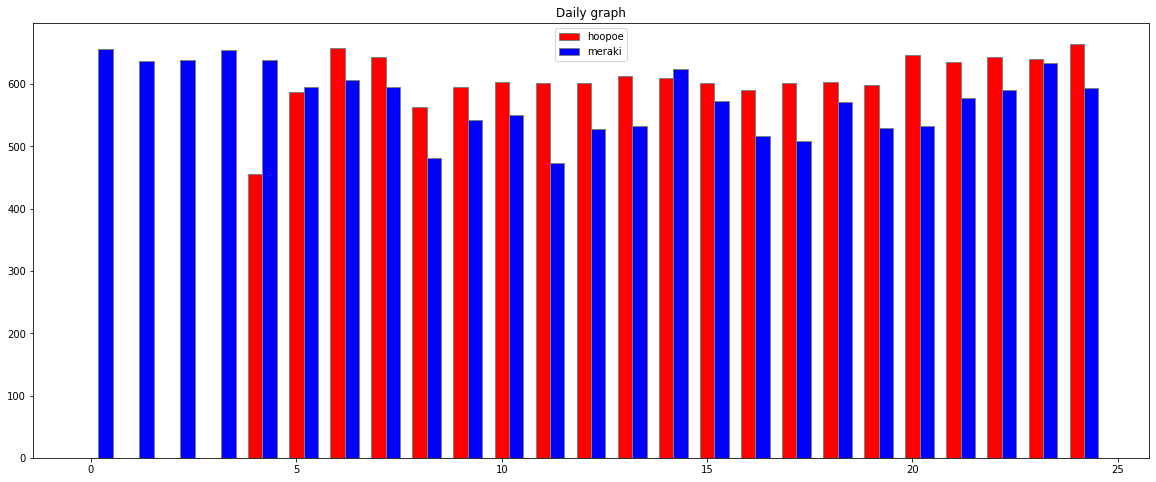

In [47]:
import numpy as np
import matplotlib.pyplot as plt

loyalty = pd.read_csv("Loyalty.csv", usecols = ['Daily','Weekly','Occasional','First time'])
daily_list = (daily.sum()).tolist()
daily_df = pd.DataFrame( columns= ['meraki', 'ahmed'])
daily_df['meraki'] = loyalty['Daily'].iloc[6:31]
daily_df['ahmed'] = daily_list[0:25]
# Make the plot
# Set position of bar on X axis
barWidth = 0.35
br1 = np.arange(len(daily_df['ahmed']))
br2 = [x + barWidth for x in br1]

fig = plt.subplots(figsize =(20, 8))

plt.bar(br1, daily_df['ahmed'], color ='r', width = barWidth,
        edgecolor ='grey', label ='hoopoe')
plt.bar(br2, daily_df['meraki'], color ='b', width = barWidth,
        edgecolor ='grey', label ='meraki')
plt.legend()
plt.title('Daily graph')

Text(0.5, 1.0, 'Weekly graph')

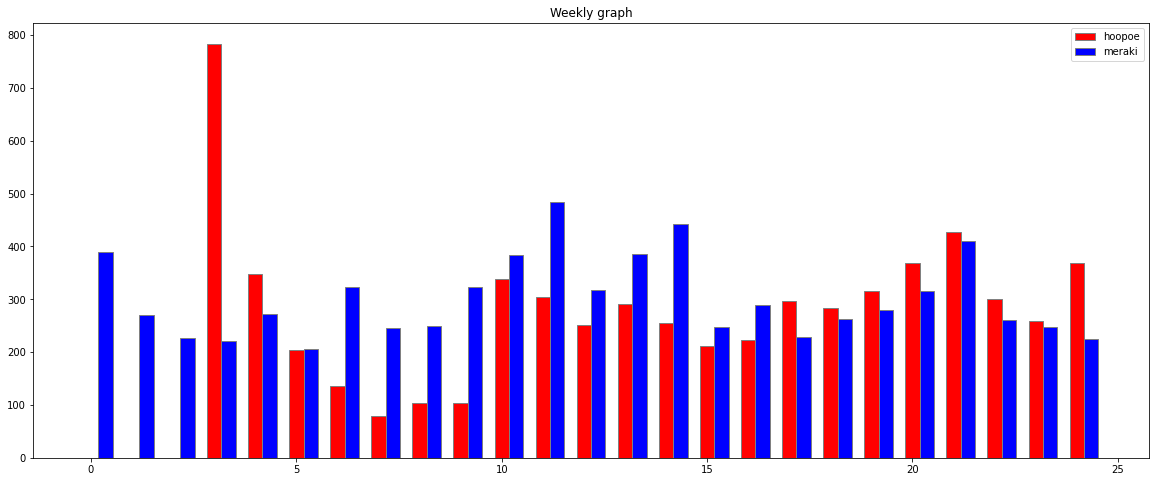

In [38]:
loyalty = pd.read_csv("Loyalty.csv", usecols = ['Daily','Weekly','Occasional','First time'])
weekly_list = (week.sum()).tolist()
weekly_df = pd.DataFrame( columns= ['meraki', 'ahmed'])
weekly_df['meraki'] = loyalty['Weekly'].iloc[6:31]
weekly_df['ahmed'] = weekly_list[0:25]
# Make the plot
# Set position of bar on X axis
barWidth = 0.35
br1 = np.arange(len(weekly_df['ahmed']))
br2 = [x + barWidth for x in br1]

fig = plt.subplots(figsize =(20, 8))

plt.bar(br1, weekly_df['ahmed'], color ='r', width = barWidth,
        edgecolor ='grey', label ='hoopoe')
plt.bar(br2, weekly_df['meraki'], color ='b', width = barWidth,
        edgecolor ='grey', label ='meraki')
plt.legend()
plt.title('Weekly graph')

Text(0.5, 1.0, 'Occasional graph')

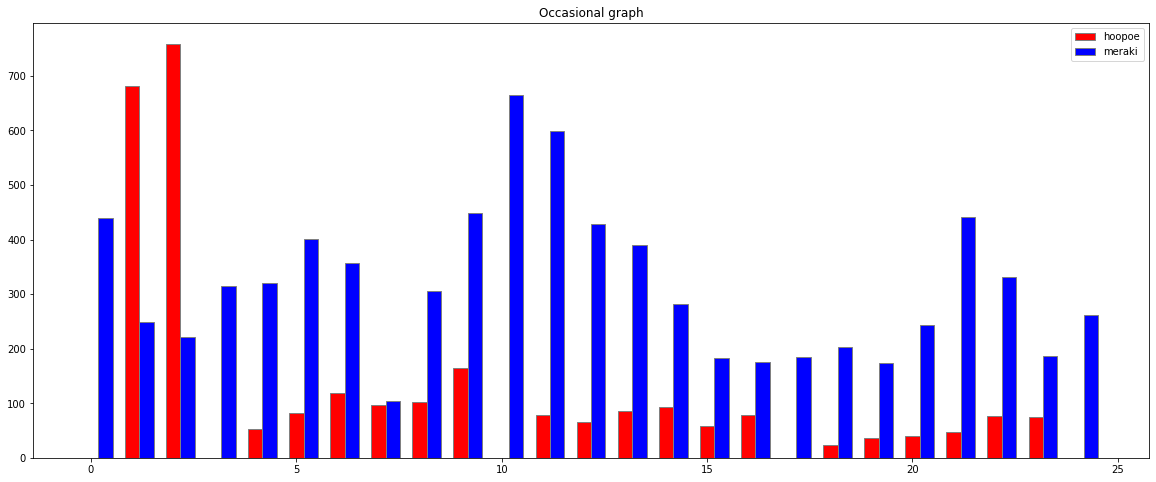

In [39]:
loyalty = pd.read_csv("Loyalty.csv", usecols = ['Daily','Weekly','Occasional','First time'])
occasional_list = (occasional.sum()).tolist()
occasional_df = pd.DataFrame( columns= ['meraki', 'ahmed'])
occasional_df['meraki'] = loyalty['Occasional'].iloc[6:31]
occasional_df['ahmed'] = occasional_list[0:25]
# Make the plot
# Set position of bar on X axis
barWidth = 0.35
br1 = np.arange(len(occasional_df['ahmed']))
br2 = [x + barWidth for x in br1]

fig = plt.subplots(figsize =(20, 8))

plt.bar(br1, occasional_df['ahmed'], color ='r', width = barWidth,
        edgecolor ='grey', label ='hoopoe')
plt.bar(br2, occasional_df['meraki'], color ='b', width = barWidth,
        edgecolor ='grey', label ='meraki')
plt.legend()
plt.title('Occasional graph')

Text(0.5, 1.0, 'First time graph')

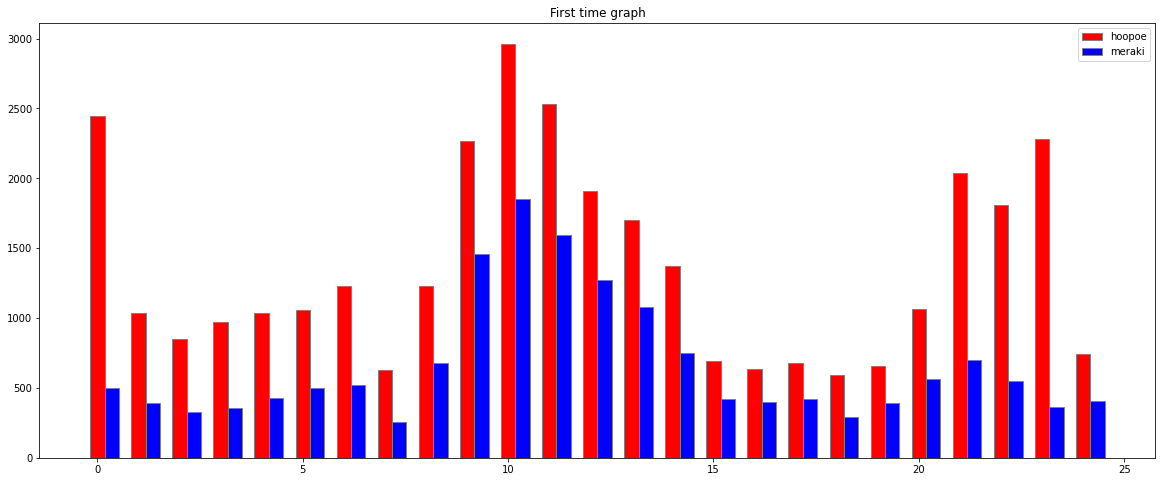

In [40]:
اloyalty = pd.read_csv("Loyalty.csv", usecols = ['Daily','Weekly','Occasional','First time'])
first_list = (first_time.sum()).tolist()
first_df = pd.DataFrame( columns= ['meraki', 'ahmed'])
first_df['meraki'] = loyalty['First time'].iloc[6:31]
first_df['ahmed'] = first_list[0:25]
# Make the plot
# Set position of bar on X axis
barWidth = 0.35
br1 = np.arange(len(first_df['ahmed']))
br2 = [x + barWidth for x in br1]

fig = plt.subplots(figsize =(20, 8))

plt.bar(br1, first_df['ahmed'], color ='r', width = barWidth,
        edgecolor ='grey', label ='hoopoe')
plt.bar(br2, first_df['meraki'], color ='b', width = barWidth,
        edgecolor ='grey', label ='meraki')
plt.legend()
plt.title('First time graph')